# Initial Set-up

In [2]:
!pip install planarity
import networkx as nx
import planarity

     |████████████████████████████████| 193 kB 4.3 MB/s 
  Created wheel for planarity: filename=planarity-0.4.1-cp37-cp37m-linux_x86_64.whl size=289641 sha256=7e14927ed9a785efee7a951994e95c2a993a4dd1ea1fc883505feef833bbe685
  Stored in directory: /root/.cache/pip/wheels/ae/19/92/2d33078fe3b703cf34dcf6a670652c1d6a58c0a2ebf2b3a68d
Successfully built planarity


In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import time

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions Needed

In [5]:
# Correlation matrix and nodes' namelist as input, graph as output
# MST Minimum Spanning Tree
def MST(corr_mat, namelist, draw = False):
  # corr_mat is the correlation matrix as np.array format
  attributes = {}
  for i in range(len(namelist)):
      attributes[i] = namelist[i]

  dist_mx = np.sqrt(2*(1-corr_mat))

  G = nx.from_numpy_matrix(dist_mx)
  MST = nx.minimum_spanning_tree(G,weight='weight')
  nx.set_node_attributes(MST, attributes, name='coin_name')
  # MST is the output minimum spanning tree graph
  if draw == True:
    nx.draw_networkx(MST, pos=None, arrows=None, with_labels=True)
  return MST


# PMFG Planar Maximally Filtered Graph
def PMFG(corr_mat, namelist, draw = False):
  attributes = {}
  for i in range(len(namelist)):
      attributes[i] = namelist[i]

  dist_mx = np.sqrt(2*(1-corr_mat))
  G = nx.from_numpy_matrix(dist_mx)

  def sort_graph_edges(G):
    sorted_edges = []
    for source, dest, data in sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse = True): 
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data['weight']})
    return sorted_edges # a list of dict

  PMFG = nx.Graph()
  ne_total = G.number_of_edges()
  nb_nodes = len(G.nodes)
  ne_pmfg = 3*(nb_nodes-2)
  sorted_edges = sort_graph_edges(G)
  t0 = time.time()
  for i, edge in enumerate(sorted_edges):
      PMFG.add_edge(edge['source'], edge['dest'], weight = edge['weight'])
      if not planarity.is_planar(PMFG):
          PMFG.remove_edge(edge['source'], edge['dest'])
      ne = PMFG.number_of_edges()
      # print("Generating PMFG... added edges in PMFG %d/%d (%.2f%%) lookup edges in G %d/%d (%.2f%%) Elapsed TIme %.2f [sec]"\
      #    %(ne, ne_pmfg, (ne/ne_pmfg)*100, i, ne_total, (i+1/ne_total)*100, time.time()-t0), end="\r")
      if ne == ne_pmfg:
          break
  nx.set_node_attributes(PMFG, attributes, name='coin_name')
  if draw == True:
    nx.draw_networkx(PMFG, pos=None, arrows=None, with_labels=True)
  return PMFG
  

In [6]:
import datetime

def datetime_generator(start,end,interval=1):
  # start,end are date as string format, like '12-04-2021'
  start = datetime.datetime.strptime(start, "%d-%m-%Y")
  end = datetime.datetime.strptime(end, "%d-%m-%Y")
  date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days,interval)]
  datelist = []
  for date in date_generated:
    datelist.append(date.strftime("%d-%m-%Y"))
  return datelist

In [7]:
def compute_MST_all(Corr_mat,timelist,namelist_all):
  # Input:Corr_mat is the list of corr numpy.ndarrary
  # timelist is the list of time
  # namelist_all is the list of namelist from .json file
  MST_dict = {}
  for i in range(len(Corr_mat)):
    MST_dict[timelist[i]] = MST(Corr_mat[i], namelist_all[i])
  return MST_dict
  #return a dictionary of MST, with keys of date, values of graph

In [8]:
def compute_PMFG_all(Corr_mat,timelist,namelist_all):
  PMFG_dict = {}
  for i in range(len(Corr_mat)):
    PMFG_dict[timelist[i]] = PMFG(Corr_mat[i], namelist_all[i])
  return PMFG_dict
  #return a dictionary of MST, with keys of date, values of graph

In [9]:
import collections

def sort_NodesDegree(MST_dict,namelist_all):
  # compute the nodes with max average degree
  degree_dict_list = []
  i_g = 0
  for g in MST_dict.values():
    degree_dict = {}
    for n in g.nodes():
      degree_dict[namelist_all[i_g][n]] = g.degree(n)
    degree_dict_list.append(degree_dict)
    i_g += 1
    # got a list of dict, with keys of coin names and values of number of degree 
  counter = collections.Counter()
  for d in degree_dict_list: 
    counter.update(d)
  result = dict(counter)
  sortdict = dict(sorted(result.items(), key=lambda x:x[1],reverse=True))
  return sortdict
  # Got the order of nodes with the most degree in MST

In [10]:
def time_degree(G_dict,coin,namelist_all):
  time_degree = {}
  i = 0
  for g in G_dict.values(): 
    if coin in namelist_all[i]:
      time_degree[list(G_dict.keys())[i]] = g.degree(namelist_all[i].index(coin))
    else:
      time_degree[list(G_dict.keys())[i]] = 0
    i += 1
  return time_degree

In [11]:
def plot_MST(G):
  fig, ax = plt.subplots(1,1,figsize=(10, 10))
  pos = nx.spring_layout(G)
  labels = nx.get_node_attributes(G, 'coin_name')
  nx.draw(G,with_labels=True,labels=labels,pos=pos,
        node_size=20, font_size=10, edge_color='lightgray',
        node_color='lightblue')

In [12]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
def plot_acf_coin(coin,MST_dict,namelist_all):
  x = pd.DataFrame.from_dict(time_degree(MST_dict,coin,namelist_all),orient='index')
  fig = tsaplots.plot_acf(x = x[0])
  plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [279]:
# Load correlation matrix
Corr_m_12 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/12_11_M_1d.npy',allow_pickle=True)
# Corr_d_04 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0412_0615_1d_30m.npy',allow_pickle=True)
## Corr_w_04 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0412_0615_1W_3h.npy',allow_pickle=True)
# Corr_d_08 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0816_1018_1d_30m.npy',allow_pickle=True)
## Corr_w_08 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0816_1018_1W_3h.npy',allow_pickle=True)

In [39]:
# Load namelist.json
import json
import io
from google.colab import files
uploaded = files.upload()

Saving 0816_1018_1W_3h_namelist.json to 0816_1018_1W_3h_namelist.json


In [40]:
file_name = "0816_1018_1W_3h_namelist.json"
io.StringIO(uploaded[file_name].decode("utf-8"))

In [18]:
namelist_all_m_12 = json.loads(uploaded[file_name].decode("utf-8"))

In [135]:
namelist_all_d_04 = json.loads(uploaded[file_name].decode("utf-8"))

In [32]:
namelist_all_w_04 = json.loads(uploaded[file_name].decode("utf-8"))

In [138]:
namelist_all_d_08 = json.loads(uploaded[file_name].decode("utf-8"))

In [41]:
namelist_all_w_08 = json.loads(uploaded[file_name].decode("utf-8"))

# Analysis(A year monthly)

From Year-scale monthly data, from 12-2020 to 11-2021

In [13]:
Corr_m_12 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/12_11_M_1d.npy',allow_pickle=True)

In [14]:
timelist_m_12 = ['12-2020','01-2021','02-2021','03-2021','04-2021','05-2021','06-2021','07-2021','08-2021','09-2021','10-2021','11-2021']

In [19]:
MST_m_12 = compute_MST_all(Corr_m_12, timelist_m_12, namelist_all_m_12)

In [20]:
PMFG_m_12= compute_PMFG_all(Corr_m_12, timelist_m_12, namelist_all_m_12)

In [344]:
def plot_MST(G):
  fig, ax = plt.subplots(1,1,figsize=(10, 10))
  pos = nx.spring_layout(G)
  labels = nx.get_node_attributes(G, 'coin_name')
  nx.draw(G,with_labels=True,labels=labels,pos=pos,
        node_size=20, font_size=10, edge_color='lightgray',
        node_color='lightblue')
  
def plot_PMFG(G):
  fig, ax = plt.subplots(1,1,figsize=(10, 10))
  pos = nx.spring_layout(G)
  labels = nx.get_node_attributes(G, 'coin_name')
  nx.draw(G,with_labels=True,labels=labels,pos=pos,
        node_size=20, font_size=10, edge_color='lightgray',
        node_color='lightblue')

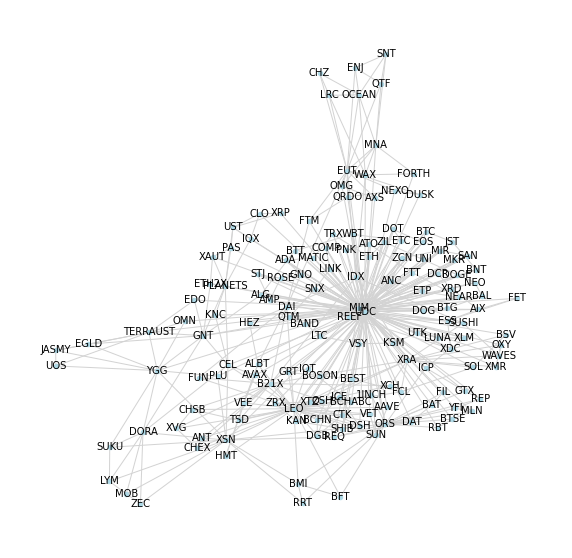

In [345]:
plot_PMFG(PMFG_m_12['11-2021'])

In [21]:
print(sort_NodesDegree(PMFG_m_12, namelist_all_m_12))

{'DAI': 334, 'UDC': 333, 'LEO': 265, 'UST': 262, 'TSD': 246, 'PAX': 221, 'XAUT': 162, 'CLO': 139, 'SOL': 131, 'EUT': 127, 'RRT': 122, 'XRA': 94, 'B21X': 91, '1INCH': 87, 'YGG': 84, 'SUKU': 81, 'ANT': 70, 'PLANETS': 67, 'BCHABC': 66, 'MIM': 64, 'AMP': 63, 'HEZ': 61, 'GOT': 61, 'BTSE': 61, 'XSN': 60, 'PAS': 58, 'SAN': 56, 'QTM': 56, 'ENJ': 55, 'EDO': 54, 'MLN': 54, 'XVG': 53, 'ETP': 53, 'UOS': 53, 'VSY': 53, 'GNT': 53, 'YFI': 52, 'QSH': 52, 'ADA': 51, 'MKR': 51, 'WAX': 51, 'GTX': 50, 'XTZ': 50, 'FET': 50, 'BCHN': 50, 'ESS': 50, 'ZIL': 49, 'DAT': 49, 'XRP': 49, 'OMG': 49, 'MNA': 49, 'IQX': 49, 'JST': 49, 'VET': 49, 'BAND': 49, 'FIL': 49, 'BTG': 49, 'XDC': 49, 'EGLD': 48, 'NEO': 48, 'ALG': 48, 'UOP': 48, 'BAT': 47, 'BSV': 47, 'IOT': 47, 'DGB': 47, 'DOT': 47, 'XCH': 47, 'DOG': 47, 'SNX': 46, 'BTT': 46, 'ZRX': 46, 'TRX': 46, 'ETH': 46, 'KSM': 46, 'UNI': 46, 'DSH': 46, 'ATO': 46, 'BFT': 46, 'KNC': 45, 'COMP': 45, 'LTC': 45, 'PLU': 45, 'EOS': 44, 'LINK': 44, 'BAL': 44, 'FTT': 43, 'XLM': 43, 'F

In [22]:
def plot_ts_coin(coins,G_dict,namelist_all):
  plt.figure(figsize=(8, 3))
  for i in range(len(coins)):
    ts_degree = time_degree(G_dict,coins[i],namelist_all)
    x,y = zip(*ts_degree.items())
    plt.plot(x,y,label=coins[i])
  plt.ylabel('Degree')
  ax = plt.gca()
  plt.xticks(rotation=40,fontsize=9)
  plt.legend()
  plt.show()

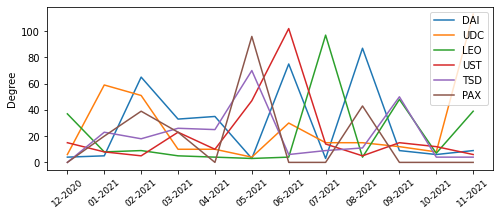

In [23]:
plot_ts_coin(['DAI','UDC','LEO','UST','TSD','PAX'], PMFG_m_12, namelist_all_m_12)

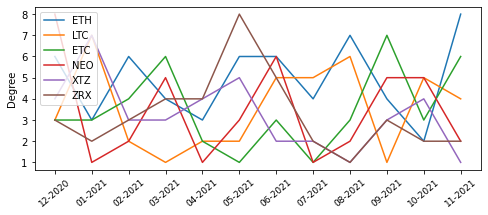

In [306]:
plot_ts_coin(['ETH','LTC','ETC','NEO','XTZ','ZRX'], MST_m_12, namelist_all_m_12)

In [25]:
%matplotlib inline

def plot_acf_coins(coins,G_dict,namelist_all):
  # shoule be 6 coins passed
  fig, axs = plt.subplots(2,3,figsize=(20,10))
  for i in range(len(coins)):
    x = pd.DataFrame.from_dict(time_degree(G_dict,coins[i],namelist_all),orient='index')
    ax = axs.reshape(-1)[i]
    tsaplots.plot_acf(x = x[0],ax=ax,title='Autocorrelation of the degree of '+coins[i])
  plt.show()


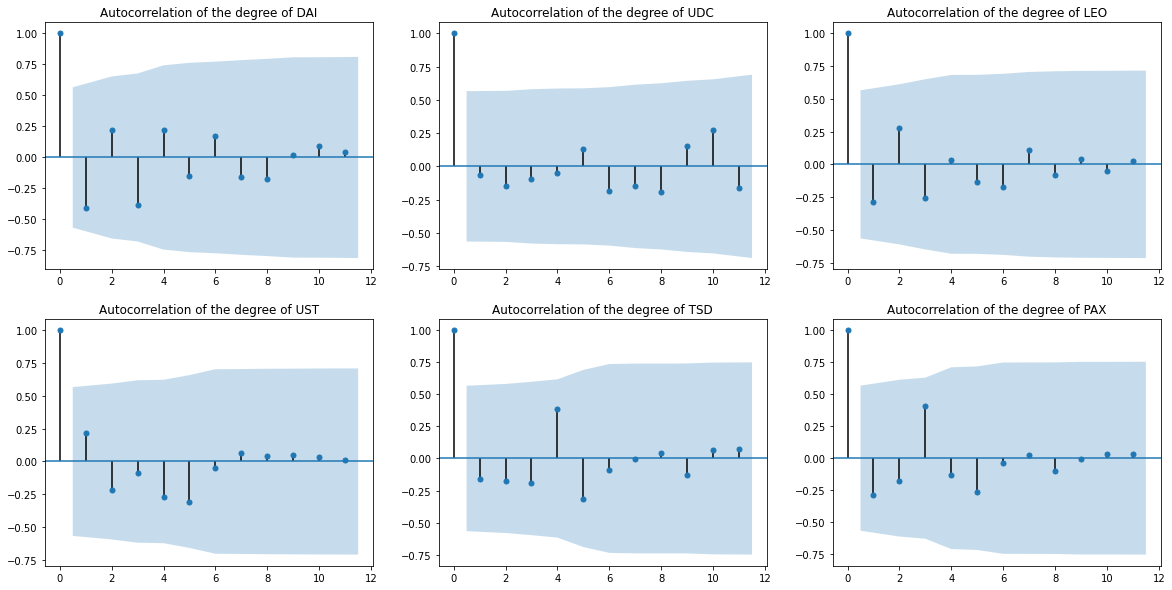

In [26]:
plot_acf_coins(['DAI','UDC','LEO','UST','TSD','PAX'], PMFG_m_12, namelist_all_m_12)

# Analysis(0412-0615)

Analysis for time period 12 Apr.- 15 Jun.

In [27]:
Corr_w_04 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0412_0615_1W_3h.npy',allow_pickle=True)

In [33]:
timelist_w_04 = datetime_generator('12-04-2021','15-06-2021',7) # interval is number of days
#MST_w_04 = compute_MST_all(Corr_w_04, timelist_w_04, namelist_all_w_04)

In [ ]:
MST_w_04 = compute_MST_all(Corr_w_04, timelist_w_04, namelist_all_w_04)

In [34]:
PMFG_w_04 = compute_PMFG_all(Corr_w_04, timelist_w_04, namelist_all_w_04)

In [313]:
print(sort_NodesDegree(MST_w_04,namelist_all_w_04))
coins_focus = list(sort_NodesDegree(MST_w_04,namelist_all_w_04).keys())[:6]
print(coins_focus)

{'ETH': 54, 'TRX': 50, 'BTC': 40, 'EOS': 36, 'JST': 34, 'BAL': 34, 'OMG': 32, 'BAT': 32, 'XTZ': 30, 'NEO': 29, 'LINK': 29, 'LTC': 28, 'DSH': 27, 'UNI': 26, 'BCHN': 26, 'BAND': 24, 'ADA': 24, 'DOT': 24, 'FET': 23, 'VET': 22, 'SNX': 21, 'ZIL': 20, 'AAVE': 20, 'ATO': 20, 'BTT': 19, 'ENJ': 19, 'HEZ': 19, 'XRP': 18, 'ZEC': 18, 'YFI': 18, 'ZRX': 18, 'AVAX': 18, 'UST': 17, 'EGLD': 17, 'DAI': 16, 'DOGE': 16, 'SUSHI': 15, 'XDC': 15, 'ALG': 15, 'MNA': 15, 'EDO': 15, 'XMR': 15, 'WBT': 15, 'ETC': 15, 'ETP': 15, 'IOT': 15, 'SOL': 15, 'LUNA': 15, 'KNC': 14, 'QTM': 14, 'GTX': 14, 'SAN': 14, 'XAUT': 14, 'CLO': 14, 'GNT': 14, 'COMP': 13, 'BTG': 13, 'XVG': 13, 'XSN': 13, 'BSV': 13, 'RBT': 13, 'KSM': 12, 'LEO': 12, 'XLM': 12, 'BOSON': 12, 'VSY': 12, 'BCHABC': 12, 'FIL': 12, 'YGG': 12, 'ANT': 12, 'REP': 12, 'AMP': 11, 'UDC': 11, 'UOS': 11, 'SUN': 11, 'UOP': 11, 'CHZ': 11, 'IQX': 11, 'DGB': 11, 'DAT': 11, 'CEL': 10, 'MKR': 10, 'ESS': 10, 'TSD': 10, 'DOG': 10, 'MLN': 10, 'NEAR': 10, 'STJ': 10, 'GNO': 10, 'P

In [35]:
print(sort_NodesDegree(PMFG_w_04,namelist_all_w_04))
coins_focus = list(sort_NodesDegree(PMFG_w_04,namelist_all_w_04).keys())[:6]
print(coins_focus)

{'UST': 452, 'UDC': 327, 'DAI': 262, 'XRA': 200, 'TSD': 124, 'XAUT': 108, 'UOP': 106, 'CLO': 103, 'EUT': 66, 'XSN': 60, 'BCHABC': 56, 'UOS': 52, 'PLU': 50, 'OMN': 46, 'MLN': 46, 'ETP': 44, 'YGG': 44, 'LEO': 43, 'SOL': 42, 'DOG': 41, 'BTG': 41, 'CEL': 40, 'SAN': 40, 'ALBT': 40, 'VSY': 39, 'MOB': 39, 'ZIL': 39, 'XLM': 38, 'GTX': 38, 'MNA': 37, 'EDO': 37, 'HEZ': 37, 'QTM': 37, 'BSV': 37, 'SUN': 36, 'ZRX': 36, 'BAL': 36, 'SUSHI': 36, 'AVAX': 36, 'BOSON': 36, 'ATO': 36, 'XMR': 36, 'VET': 36, 'BAND': 36, 'ETC': 36, 'ALG': 35, 'KSM': 35, 'AMP': 35, 'EOS': 35, 'COMP': 35, 'SNX': 35, 'ZEC': 34, 'EGLD': 34, 'DOT': 34, 'ADA': 34, 'WBT': 34, 'BAT': 34, 'ESS': 34, 'BTC': 34, 'XRP': 34, 'BTSE': 34, 'LINK': 33, 'FET': 33, 'ETH': 33, 'DSH': 33, 'TRX': 33, 'IOT': 33, 'FIL': 33, 'CHZ': 33, 'MKR': 33, 'YFI': 33, 'BCHN': 33, 'UNI': 33, 'XDC': 33, 'NEO': 33, 'REP': 33, 'RBT': 33, 'JST': 32, 'AAVE': 32, 'DGB': 32, 'IQX': 31, 'LTC': 31, 'XTZ': 31, 'LUNA': 31, 'NEAR': 31, 'KNC': 30, 'OMG': 30, 'XVG': 30, 'GNT

In [315]:
coins_focus = list(sort_NodesDegree(MST_w_04,namelist_all_w_04).keys())[:6]
print(coins_focus)

['ETH', 'TRX', 'BTC', 'EOS', 'JST', 'BAL']


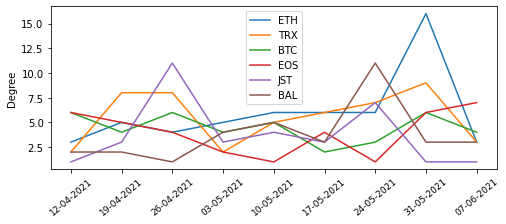

In [316]:
plot_ts_coin(coins_focus, MST_w_04, namelist_all_w_04)

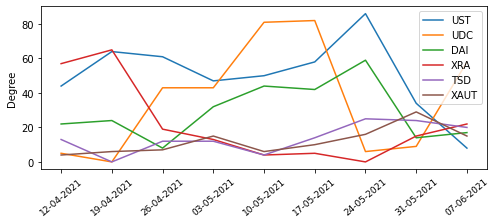

In [36]:
plot_ts_coin(coins_focus, PMFG_w_04, namelist_all_w_04)

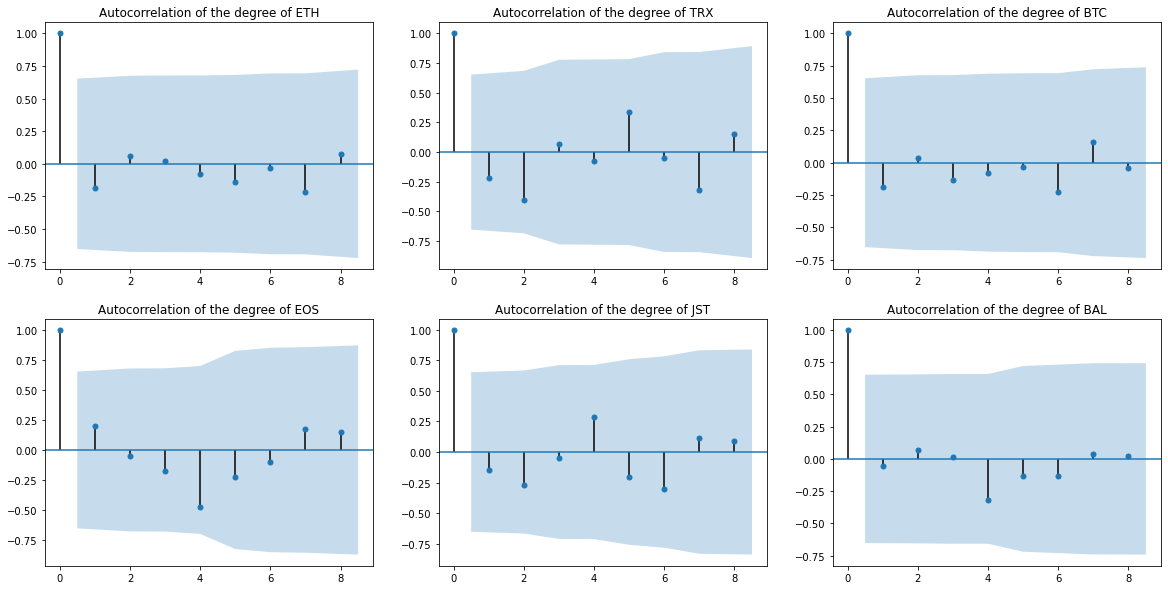

In [317]:
plot_acf_coins(coins_focus, MST_w_04, namelist_all_w_04)

# Analysis(0816-1018)

Analysis for time period 0816-1018

In [37]:
Corr_w_08 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0816_1018_1W_3h.npy',allow_pickle=True)

In [38]:
timelist_w_08 = datetime_generator('16-08-2021','18-10-2021',7) # interval is number of days

In [323]:
MST_w_08 = compute_MST_all(Corr_w_08, timelist_w_08, namelist_all_w_08)

In [42]:
PMFG_w_08 = compute_PMFG_all(Corr_w_08, timelist_w_08, namelist_all_w_08)

In [340]:
print(sort_NodesDegree(MST_w_08,namelist_all_w_08))
coins_focus_w08 = list(sort_NodesDegree(MST_w_08,namelist_all_w_08).keys())[:6]
print(coins_focus_w08)

{'ETH': 59, 'TRX': 41, 'AAVE': 40, 'ETC': 40, 'NEO': 35, 'BTC': 31, 'DSH': 31, 'LINK': 30, 'BAL': 27, 'BAT': 26, 'DOGE': 24, 'DOT': 24, 'XRP': 23, 'WBT': 23, 'BCHN': 23, 'UNI': 22, 'XTZ': 21, 'JST': 21, 'GRT': 21, 'ZRX': 20, 'EOS': 20, 'SUSHI': 19, 'LTC': 19, 'ZEC': 19, 'IOT': 19, 'SNX': 17, 'STJ': 17, 'VET': 17, 'OCEAN': 16, 'XVG': 16, 'MNA': 16, 'YFI': 16, 'BSV': 16, 'COMP': 15, 'OXY': 15, 'BAND': 15, 'ADA': 15, 'ICP': 15, '1INCH': 15, 'REP': 15, 'NEAR': 14, 'WAVES': 14, 'LUNA': 14, 'UST': 14, 'XLM': 14, 'XAUT': 14, 'FIL': 14, 'SOL': 14, 'CEL': 13, 'DGB': 13, 'ZCN': 13, 'IQX': 13, 'GNO': 13, 'PNK': 13, 'REEF': 13, 'BTT': 12, 'KSM': 12, 'UDC': 12, 'UOS': 12, 'SUN': 12, 'MIR': 12, 'RBT': 12, 'BFT': 12, 'AVAX': 12, 'XCH': 11, 'OMG': 11, 'FET': 11, 'ALG': 11, 'QTM': 11, 'KAN': 11, 'EDO': 11, 'XMR': 11, 'LRC': 11, 'XSN': 11, 'IDX': 11, 'EUT': 11, 'NEXO': 11, 'ATO': 11, 'XDC': 10, 'BTSE': 10, 'BOSON': 10, 'EGLD': 10, 'ETP': 10, 'TSD': 10, 'DAI': 10, 'DOG': 10, 'FCL': 10, 'MLN': 10, 'PLU': 

In [43]:
print(sort_NodesDegree(PMFG_w_08,namelist_all_w_08))
coins_focus_w08 = list(sort_NodesDegree(PMFG_w_08,namelist_all_w_08).keys())[:6]
print(coins_focus_w08)

{'UST': 239, 'UDC': 218, 'XAUT': 201, 'TSD': 165, 'EUT': 162, 'PLU': 146, 'LEO': 142, 'XSN': 96, 'DAI': 89, 'B21X': 88, 'CLO': 83, 'XRA': 70, 'ESS': 61, 'YGG': 59, 'BCHABC': 57, 'HEZ': 55, 'ETP': 54, 'XCH': 52, 'IDX': 51, 'ZCN': 50, 'SAN': 45, 'CEL': 43, 'IQX': 43, 'BTSE': 42, 'BFT': 39, 'GNO': 39, 'MLN': 38, 'NEAR': 38, 'LRC': 38, 'UOS': 37, 'LUNA': 36, 'SUN': 35, 'DGB': 35, 'EDO': 34, 'GNT': 34, 'DOGE': 33, 'MNA': 33, 'FET': 33, 'ATO': 33, 'KAN': 33, 'AVAX': 33, 'SOL': 33, 'BTC': 32, 'XMR': 32, 'OMG': 32, 'FIL': 32, 'BCHN': 32, 'XLM': 32, 'XVG': 32, 'ALG': 32, 'VSY': 32, 'FCL': 32, 'XRD': 32, '1INCH': 31, 'IOT': 31, 'XRP': 31, 'DOG': 31, 'FTM': 31, 'ETH': 31, 'KSM': 31, 'ADA': 31, 'REP': 31, 'WBT': 31, 'RBT': 31, 'BOSON': 31, 'PNK': 31, 'ZRX': 30, 'JST': 30, 'DOT': 30, 'EOS': 30, 'LTC': 30, 'ZEC': 30, 'XDC': 30, 'BSV': 30, 'EGLD': 30, 'OCEAN': 30, 'YFI': 30, 'WAVES': 30, 'MIR': 30, 'BAND': 30, 'MOB': 30, 'XTZ': 29, 'TRX': 29, 'STJ': 29, 'SNX': 29, 'UNI': 29, 'DSH': 29, 'GRT': 29, 'IC

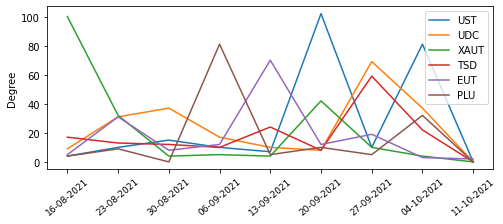

In [44]:
plot_ts_coin(['UST', 'UDC', 'XAUT', 'TSD', 'EUT', 'PLU'], PMFG_w_08, namelist_all_w_08)

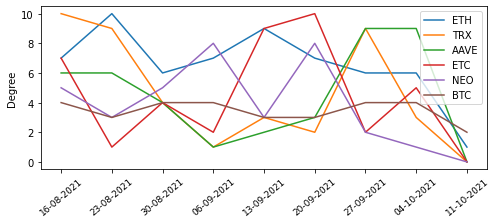

In [346]:
plot_ts_coin(['ETH', 'TRX', 'AAVE', 'ETC', 'NEO', 'BTC'], MST_w_08, namelist_all_w_08)

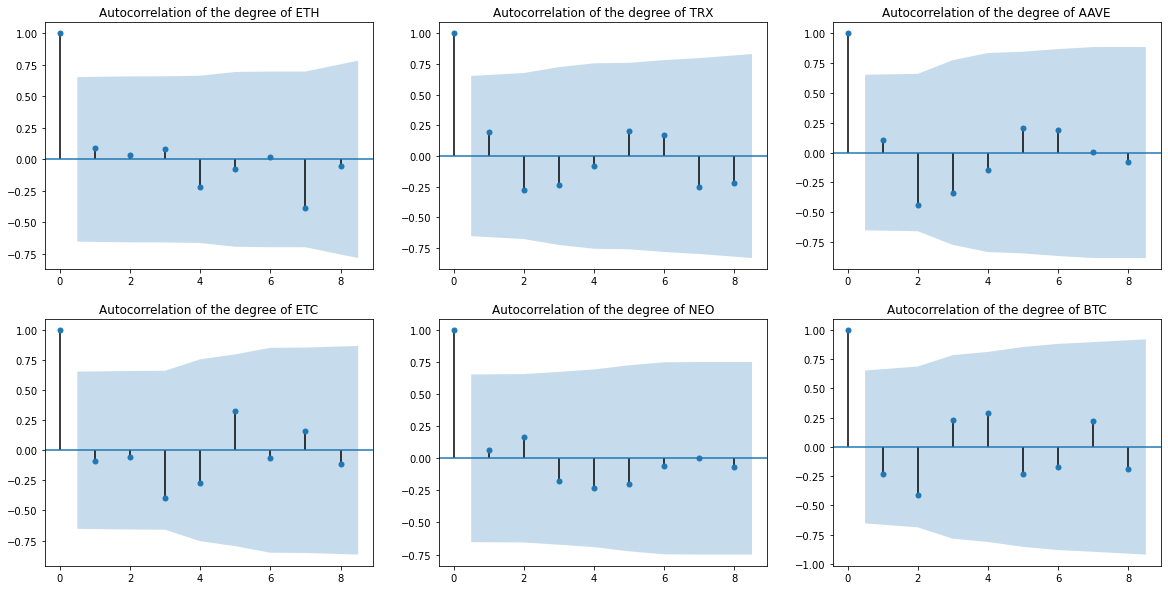

In [341]:
plot_acf_coins(coins_focus_w08, MST_w_08, namelist_all_w_08)